# Setup

In [1]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from tqdm import tqdm
warnings.filterwarnings("ignore")

import sklearn.linear_model as lm

# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import hdmpy as hdm

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import dml_test
sns.set(font_scale=2,style='whitegrid')
np.random.seed(0)

In [2]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import hdmpy as hdmpy

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## Loading STAR Dataset

In [3]:
STAR_High_School = pd.read_spss('PROJECTSTAR/STAR_High_Schools.sav')
STAR_K3_School = pd.read_spss('PROJECTSTAR/STAR_K-3_Schools.sav').set_index('schid')
STAR_Students = pd.read_spss('PROJECTSTAR/STAR_Students.sav').set_index('stdntid')
Comparison_Students = pd.read_spss('PROJECTSTAR/Comparison_Students.sav').set_index('stdntid')

# pre-treatment covariates
gk_cols = list(filter(lambda x: 'gk' in x, STAR_Students.columns))
g1_cols = list(filter(lambda x: 'g1' in x, STAR_Students.columns))
g2_cols = list(filter(lambda x: 'g2' in x, STAR_Students.columns))
g3_cols = list(filter(lambda x: 'g3' in x, STAR_Students.columns))
g_cols = gk_cols+g1_cols+g2_cols+g3_cols

personal_cols = ['gender','race','birthyear']

cols_cond = ['surban',
            'tgen',
            'trace',
            'thighdegree',
            'tcareer',
            'tyears',
            'classsize',
            'freelunch']

class_sizes = ['g1classsize',
             'g2classsize']

g3scores = ['g3treadss',
            'g3tmathss',
            'g3tlangss',
            'g3socialsciss']

g_cols_cond = list(filter(lambda s: np.sum(list(map(lambda x: x in s,cols_cond)))>0,g_cols))

df_exp = STAR_Students[personal_cols]#+class_sizes]
df_exp['Sample'] = 1
df_exp['g3avgscore'] = STAR_Students[g3scores].mean(axis=1)
df_exp['g3smallclass'] = (STAR_Students['g3classsize']<=17).astype(int)

df_obs = Comparison_Students[personal_cols]#+class_sizes]
df_obs['Sample'] = 0
df_obs['g3avgscore'] = Comparison_Students[g3scores].mean(axis=1)
df_obs['g3smallclass'] = (Comparison_Students['g3classsize']<=17).astype(int)



In [4]:
df = pd.concat([df_exp])
df_no_na = df.dropna()

df_no_na_dummified = pd.get_dummies(df_no_na,columns=['gender','race'],drop_first=True)

In [5]:
df

,gender,race,birthyear,Sample,g3avgscore,g3smallclass
stdntid,,,,,,
10000.0,MALE,WHITE,1979.0,1,597.00,0
10001.0,MALE,WHITE,1980.0,1,NaN,0
10002.0,FEMALE,BLACK,1979.0,1,576.50,0
10003.0,MALE,WHITE,1980.0,1,616.50,0
10004.0,FEMALE,BLACK,1980.0,1,619.00,0
...,...,...,...,...,...,...
21596.0,FEMALE,WHITE,NaN,1,NaN,0
21597.0,FEMALE,WHITE,1979.0,1,632.00,1
21598.0,FEMALE,BLACK,1980.0,1,NaN,0


In [6]:
df_no_na_dummified

,birthyear,Sample,g3avgscore,g3smallclass,gender_MALE,race_BLACK,race_HISPANIC,race_NATIVE AMERICAN,race_OTHER,race_WHITE
stdntid,,,,,,,,,,
10000.0,1979.0,1,597.00,0,True,False,False,False,False,True
10002.0,1979.0,1,576.50,0,False,True,False,False,False,False
10003.0,1980.0,1,616.50,0,True,False,False,False,False,True
10004.0,1980.0,1,619.00,0,False,True,False,False,False,False
10005.0,1980.0,1,597.50,0,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
21589.0,1980.0,1,632.75,0,True,False,False,False,False,True
21594.0,1979.0,1,585.50,0,False,True,False,False,False,False
21597.0,1979.0,1,632.00,1,False,False,False,False,False,True


In [7]:
model_1 = "g3avgscore ~ g3smallclass"
est_1 = smf.ols(formula=model_1 , data=df_no_na).fit()

print(est_1.summary())

                            OLS Regression Results                            
Dep. Variable:             g3avgscore   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     53.23
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           3.33e-13
Time:                        19:58:18   Log-Likelihood:                -31787.
No. Observations:                6360   AIC:                         6.358e+04
Df Residuals:                    6358   BIC:                         6.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      616.0166      0.533   1156.448   

In [8]:
model_2 = "g3avgscore ~ g3smallclass + C(race) + C(gender)"
est_2 = smf.ols(formula=model_2 , data=df_no_na).fit()

print(est_2.summary())

                            OLS Regression Results                            
Dep. Variable:             g3avgscore   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     126.0
Date:                Sat, 06 Jul 2024   Prob (F-statistic):          4.44e-151
Time:                        19:58:18   Log-Likelihood:                -31456.
No. Observations:                6360   AIC:                         6.293e+04
Df Residuals:                    6353   BIC:                         6.297e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [9]:
X = df_no_na_dummified[["gender_MALE", "race_BLACK", "race_HISPANIC", "race_NATIVE AMERICAN"]]
w = df_no_na_dummified['g3smallclass']
y = df_no_na_dummified['g3avgscore']

# Fit LassoCV model to find the optimal alpha (lambda)
cv_model3a = LassoCV(alphas=None, cv=10, max_iter=10000).fit(X, w)
cv_model3b = LassoCV(alphas=None, cv=10, max_iter=10000).fit(X, y)

# Fit Lasso model with the optimal alpha
model3a = Lasso(alpha=cv_model3a.alpha_).fit(X, w)
model3b = Lasso(alpha=cv_model3b.alpha_).fit(X, y)

# Identify non-zero coefficients from Lasso models
significant_vars3a = X.columns[model3a.coef_ != 0]
significant_vars3b = X.columns[model3b.coef_ != 0]



In [10]:
# Combine the significant variables from both models
significant_vars = pd.Index(np.unique(significant_vars3a.append(significant_vars3b)))

# Extract the significant variables for regression
X_significant = X[significant_vars]

# Add 'w' to the significant variables
X_significant_with_w = X_significant.copy()
X_significant_with_w['w'] = w




In [11]:
# Add constant term for intercept in the new significant variable set
X_significant_with_w = sm.add_constant(X_significant_with_w)

In [12]:
X_significant_with_w = X_significant_with_w.apply(lambda x: x.astype(int))

In [13]:
# Fit linear regression model on significant variables plus 'w' against 'y'
model3 = sm.OLS(y, X_significant_with_w).fit()

# Print summary of the model
print("Summary for the final model with dependent variable 'y':")
print(model3.summary())

Summary for the final model with dependent variable 'y':
                            OLS Regression Results                            
Dep. Variable:             g3avgscore   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     186.7
Date:                Sat, 06 Jul 2024   Prob (F-statistic):          1.54e-151
Time:                        19:58:18   Log-Likelihood:                -31460.
No. Observations:                6360   AIC:                         6.293e+04
Df Residuals:                    6355   BIC:                         6.296e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## RLasso

In [14]:
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, time = None, clu = None, cluster = True):
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123) # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1) # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    if cluster:
      # final stage ols clustered
      dml_data = pd.concat([clu, pd.Series(time), pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    else:
      # final stage ols nonclustered
      dml_data = pd.concat([pd.Series(resy, name = 'resy'), pd.Series(resD, name = 'resD')], axis=1)

    if cluster:
      # clustered standard errors
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit(cov_type='cluster', cov_kwds={"groups": dml_data['CountyCode']})

    else:
      # regular ols
      ols_mod = smf.ols(formula = 'resy ~ 1 + resD', data = dml_data).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon


In [15]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point, # point estimate
                         'stderr': stderr, # standard error
                         'lower': point - 1.96*stderr, # lower end of 95% confidence interval
                         'upper': point + 1.96*stderr, # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)), # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)) # RMSE of model that predicts treatment D
                         }, index=[name])

In [16]:
df_no_na_dummified['intercept'] = 1
y = df_no_na_dummified['g3avgscore']
d = df_no_na_dummified['g3smallclass']
x = df_no_na_dummified[df_no_na_dummified.columns[~df_no_na_dummified.columns.isin(['g3avgscore','g3smallclass','Sample', 'intercept', 'birthyear'])]]

In [17]:
x

,gender_MALE,race_BLACK,race_HISPANIC,race_NATIVE AMERICAN,race_OTHER,race_WHITE
stdntid,,,,,,
10000.0,True,False,False,False,False,True
10002.0,False,True,False,False,False,False
10003.0,True,False,False,False,False,True
10004.0,False,True,False,False,False,False
10005.0,True,True,False,False,False,False
...,...,...,...,...,...,...
21589.0,True,False,False,False,False,True
21594.0,False,True,False,False,False,False
21597.0,False,False,False,False,False,True


In [18]:
import doubleml as dml

In [19]:
# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(df_no_na_dummified,
                                 y_col='g3avgscore',
                                 d_cols='g3smallclass',
                                 x_cols=list(x.keys()))

In [20]:
print(data_dml_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: g3avgscore
Treatment variable(s): ['g3smallclass']
Covariates: ['gender_MALE', 'race_BLACK', 'race_HISPANIC', 'race_NATIVE AMERICAN', 'race_OTHER', 'race_WHITE']
Instrument variable(s): None
No. Observations: 6360

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 6360 entries, 10000.0 to 21600.0
Columns: 11 entries, birthyear to intercept
dtypes: bool(6), float64(2), int32(1), int64(2)
memory usage: 310.5 KB



In [21]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',
                                                 Cs = Cs, max_iter=1000))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(data_dml_base,
                                ml_l = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)

lasso_summary = dml_plr_lasso.summary

print(lasso_summary)

                  coef   std err         t         P>|t|    2.5 %    97.5 %
g3smallclass  4.943606  0.855049  5.781661  7.396683e-09  3.26774  6.619472


In [23]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_l = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

print(forest_summary)

                  coef   std err         t         P>|t|     2.5 %    97.5 %
g3smallclass  6.016303  0.965009  6.234456  4.533521e-10  4.124921  7.907686


In [24]:
# Trees
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_l = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_plr_tree.fit(store_predictions=True)
tree_summary = dml_plr_tree.summary

print(tree_summary)

                  coef  std err       t         P>|t|     2.5 %    97.5 %
g3smallclass  5.977207  0.96287  6.2077  5.376576e-10  4.090017  7.864397


In [25]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary

print(boost_summary)

                  coef   std err         t         P>|t|     2.5 %    97.5 %
g3smallclass  6.050795  0.965835  6.264835  3.732192e-10  4.157794  7.943796


In [26]:
plr_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
plr_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
print(plr_summary[['coef', '2.5 %', '97.5 %']])

             coef     2.5 %    97.5 %
lasso    4.943606  3.267740  6.619472
forest   6.016303  4.124921  7.907686
tree     5.977207  4.090017  7.864397
xgboost  6.050795  4.157794  7.943796


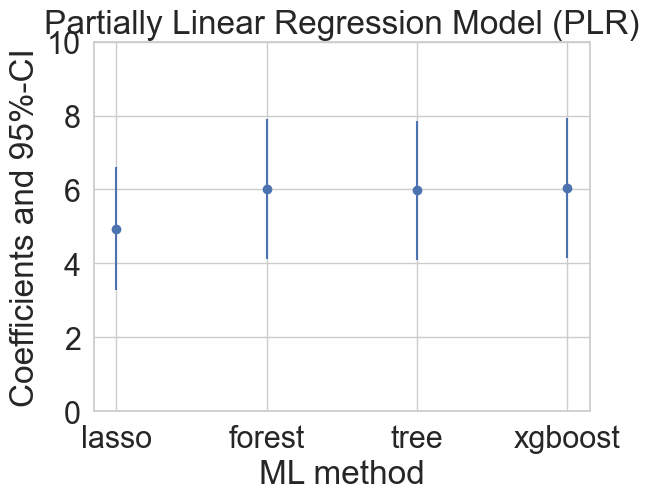

In [36]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 10])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

In [27]:
from econml.dml import CausalForestDML

In [28]:
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df_no_na_dummified['g3avgscore'], X=x, T=df_no_na_dummified['g3smallclass'])

In [32]:
from econml.cate_interpreter import SingleTreeCateInterpreter

%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, x)


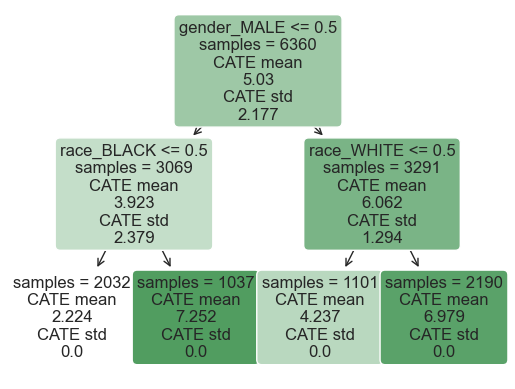

In [34]:
intrp.plot(feature_names=list(x.keys()), fontsize=12)